In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

## Load image

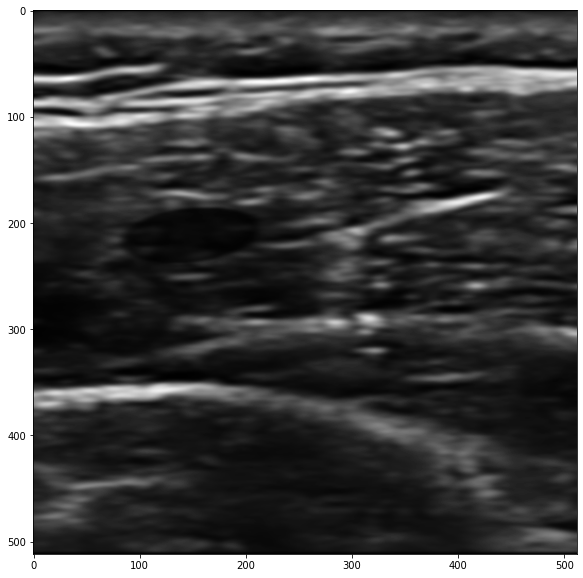

In [59]:
test_dir = "/home/zhenyuli/workspace/us_robot/DataSet/SimRealDatasetTest"
file = test_dir+"/0013/image.png"
img = cv2.imread(file, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255
plt.figure(figsize=(10, 10))
plt.imshow(img,'gray')

In [60]:
img_norm = np.array(img)
#plt.figure(figsize=(10, 10))
#plt.imshow(img,'gray')
print(np.mean(img_norm))
print(np.var(img_norm))

0.16453034
0.018754633


8.195639e-08
1.0


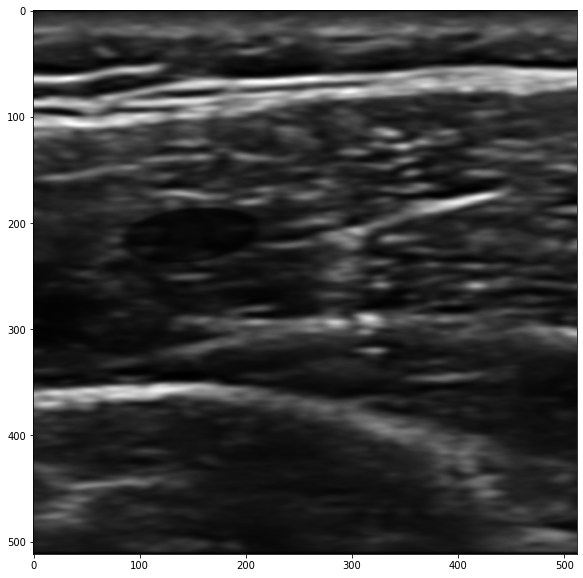

In [61]:

img -= img.mean()
img /= img.std()
img_norm = np.array(img)
print(np.mean(img_norm))
print(np.var(img_norm))
plt.figure(figsize=(10, 10))
plt.imshow(img,'gray')

## image moment

In [19]:

_,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY)
#cv2.imshow('image',img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [4]:
M = cv2.moments(img_bin)

In [5]:
cX = int(M["m10"]/M["m00"])
cY = int(M["m01"]/M["m00"])

ZeroDivisionError: float division by zero

In [6]:
mu20 = M["m20"]/M["m00"]-cX**2
mu02 = M["m02"]/M["m00"]-cY**2
mu11 = M["m11"]/M["m00"]-cX*cY

ZeroDivisionError: float division by zero

In [26]:
covI = np.array([[mu20,mu11],[mu11,mu02]])

In [27]:
w,v = np.linalg.eig(covI)

In [30]:
w

array([3560.29736887,  752.78131497])

In [31]:
v

array([[ 0.99984371,  0.01767902],
       [-0.01767902,  0.99984371]])

In [17]:
v[:,0] = [1,-1]

In [28]:
X = [cX,cX]
Y = [cY,cY]
vct = (np.sqrt(1+12*w)-1)/2*v
#vct =  w*v
U = vct[0]
V = vct[1]

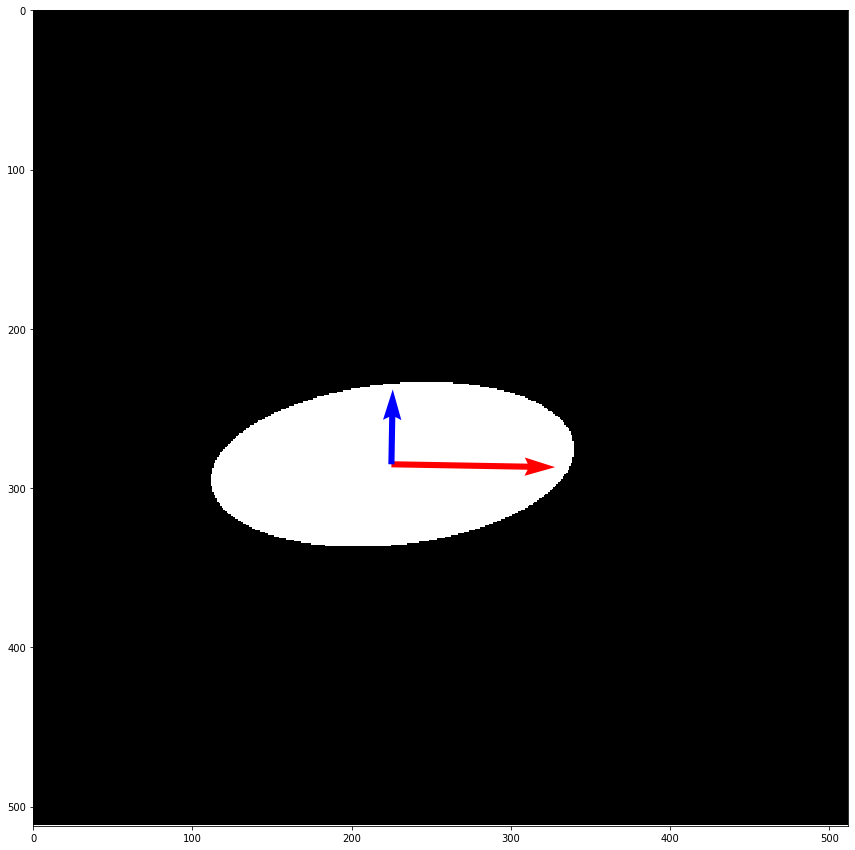

In [29]:
plt.figure(figsize=(15, 15))
ax = plt.gca()
ax.imshow(img_bin,'gray')
ax.quiver(X, Y, U, V, color = ['r','b'], angles='uv', units='x', scale=1, scale_units='x')
ax.set_xlim([0, 512])
ax.set_ylim([0, 512])
ax.invert_yaxis()

In [70]:
(np.sqrt(1+12*w)-1)/2

array([38.57695898, 46.05068073])

In [20]:
laplacian = np.abs(cv2.Laplacian(img_bin,cv2.CV_64F))

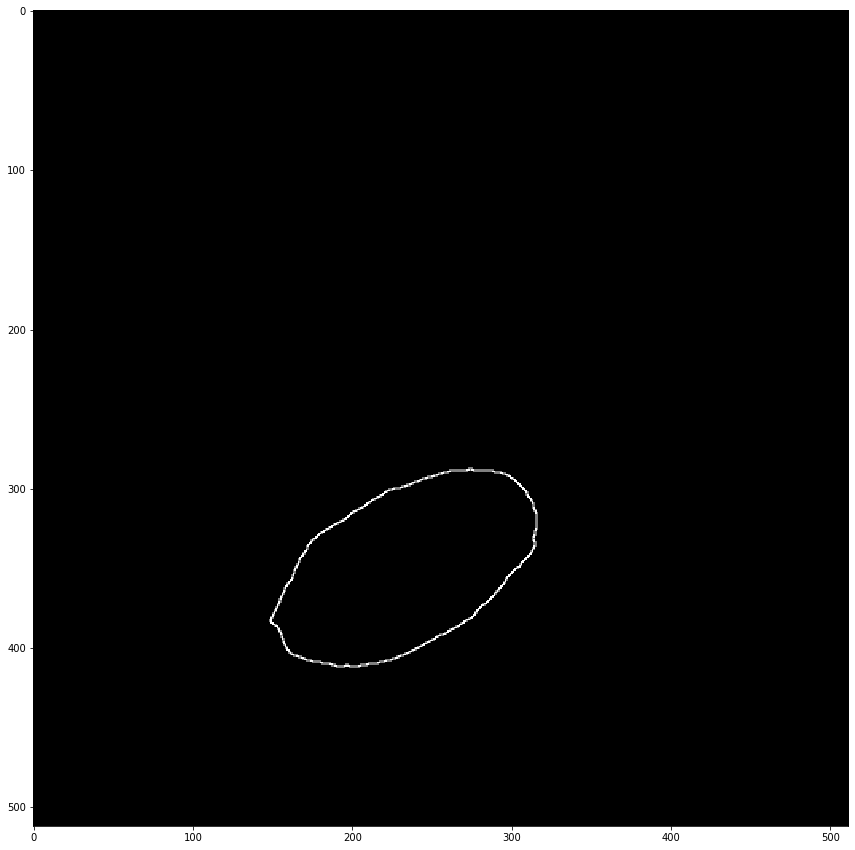

In [101]:
plt.figure(figsize=(15, 15))
plt.imshow(laplacian,cmap = 'gray')

In [22]:
_,edge_bin = cv2.threshold(laplacian,1,255,cv2.THRESH_BINARY)

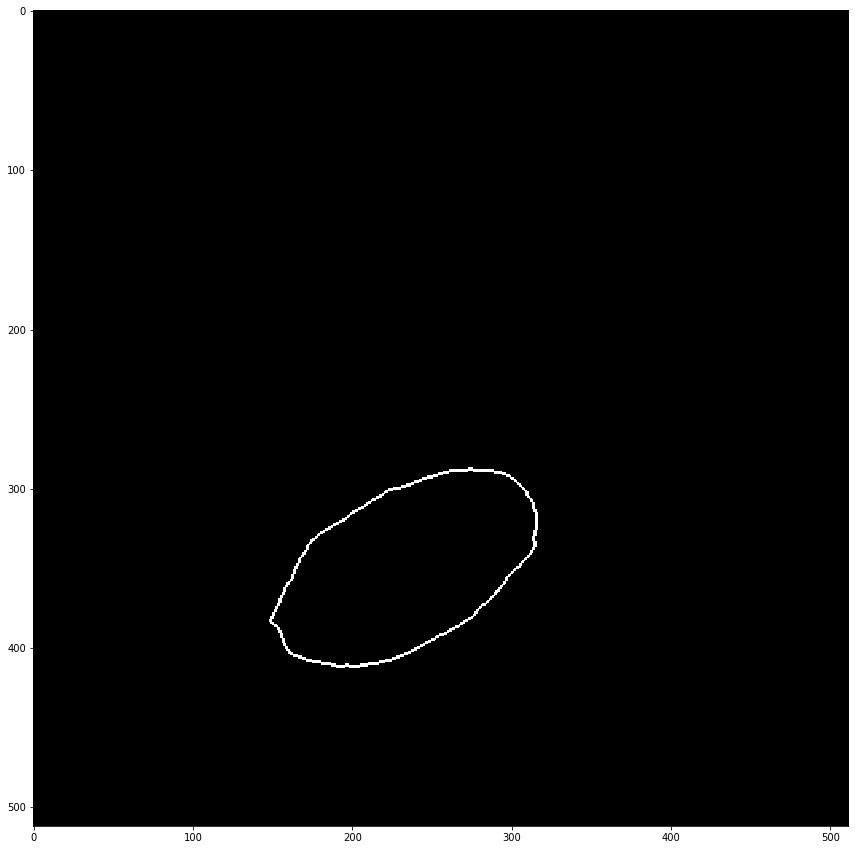

In [24]:
plt.figure(figsize=(15, 15))
plt.imshow(edge_bin,cmap='gray')

In [63]:
x,y = np.nonzero(edge_bin)
A = np.array([x**2,x*y,y**2,x,y,np.ones(len(x))]).transpose()

In [64]:
u,s,vt = np.linalg.svd(A)
a,b,c,d,e,f = list(vt[-1,:]/vt[-1,-1])

In [77]:
yv,xv = np.meshgrid(np.linspace(1,512,512),np.linspace(1,512,512))

In [78]:
A

array([[8.23690e+04, 7.83510e+04, 7.45290e+04, 2.87000e+02, 2.73000e+02,
        1.00000e+00],
       [8.23690e+04, 7.86380e+04, 7.50760e+04, 2.87000e+02, 2.74000e+02,
        1.00000e+00],
       [8.23690e+04, 7.89250e+04, 7.56250e+04, 2.87000e+02, 2.75000e+02,
        1.00000e+00],
       ...,
       [1.69744e+05, 8.32240e+04, 4.08040e+04, 4.12000e+02, 2.02000e+02,
        1.00000e+00],
       [1.69744e+05, 8.36360e+04, 4.12090e+04, 4.12000e+02, 2.03000e+02,
        1.00000e+00],
       [1.69744e+05, 8.40480e+04, 4.16160e+04, 4.12000e+02, 2.04000e+02,
        1.00000e+00]])

In [99]:
img_efit = np.abs(a*xv**2 + b*xv*yv + c*yv**2 + d*xv + e*yv + f)<2e-4

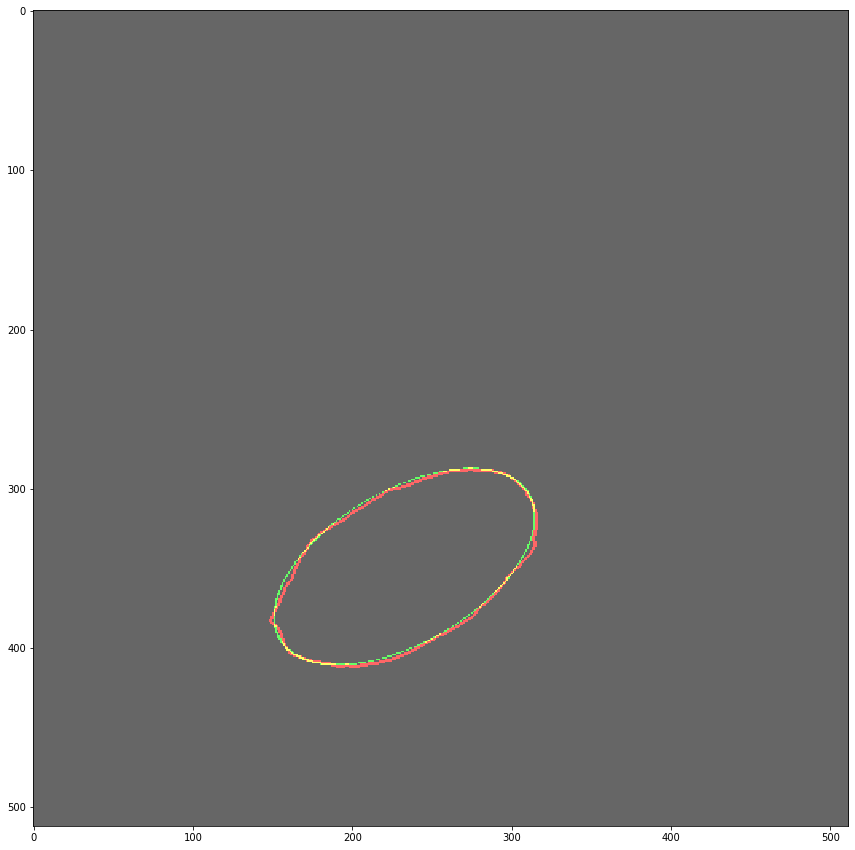

In [100]:
img_comp = np.zeros([512,512,3])
img_comp[:,:,0] = edge_bin/255
img_comp[:,:,1] = img_efit
img_comp[:,:,2]
plt.figure(figsize=(15, 15))
plt.imshow(img_comp,cmap='gray',alpha=0.6)
plt.show()

In [41]:
x = np.array([1,2,3])
y = np.array([3,2,1])
np.array([x**2,x*y,y**2,x,y,np.ones(len(x))]).transpose()

array([[1., 3., 9., 1., 3., 1.],
       [4., 4., 4., 2., 2., 1.],
       [9., 3., 1., 3., 1., 1.]])

In [2]:
cv2.namedWindow('Select Points', cv2.WINDOW_NORMAL)